# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

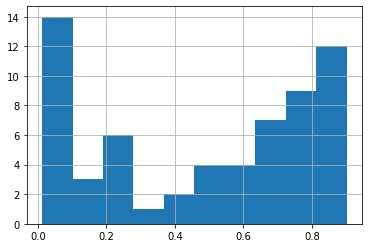

In [1]:
%run stepik_ml_test_data.ipynb

# Data manipulation
import pandas as pd
import numpy as np

#Machine learning
from sklearn import tree
from sklearn import neighbors
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import seaborn as sns

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# Базовая обработка данных

In [2]:
events_data = pd.read_csv('./data_files/stepik_ml/event_data_train.csv')

In [3]:
submissions_data = pd.read_csv('./data_files/stepik_ml/submissions_data_train.csv')

In [4]:
user_score_test = pd.read_csv('./data_files/stepik_ml/user_score_test.csv')

In [5]:
user_score_test = user_score_test.set_index('user_id')

In [6]:
# Добавим колонки даты и дня к events_data

events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [7]:
events_data['day'] = events_data.date.dt.date

In [8]:
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


<AxesSubplot:xlabel='day'>

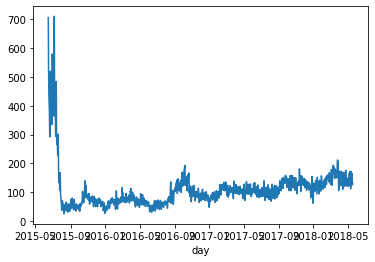

In [9]:
# Смотрим, сколько активных юзеров было в разные дни

events_data.groupby('day').user_id.nunique().plot()

<AxesSubplot:>

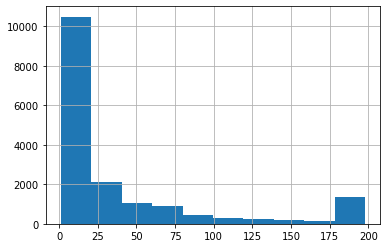

In [10]:
# Мы хотим посмотреть, сколько степов прошел каждый юзер. Сделаем неправильным способом

events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}) \
    .passed_steps.hist()

In [11]:
# Прошлый способ был неправильный, потому что не учитывал пользователей, которые не прошли ни одного степа

pivot_events = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()
pivot_events.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<AxesSubplot:>

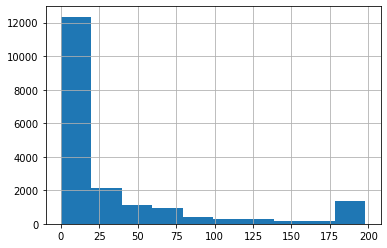

In [12]:
# В итоге у нас добавилось 2 тысячи пользователей, которые не прошли ни одного шага

pivot_events.passed.hist()

In [13]:
# Добавим колонки даты и дня к submissions_data

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [14]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


# Статистика по пользователю и по его степам

Начнем делать табличку, которая содержит данные о его успеваемости (какие шаги он прошел, какие перерывы между выполнениями заданий делал)

In [15]:
users_score = submissions_data.pivot_table(index='user_id', 
                             columns='submission_status', 
                             values='step_id', 
                             aggfunc='count',
                             fill_value=0).reset_index()

In [16]:
users_score

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [17]:
# Сначала составим таблицу, где отображается день активности и время для пользователя. То есть если пользователь 
# совершил хотя бы одно дейсвтие в один день, мы этот день вносим в таблицу (если действий несколько, мы все равно вносим 
# только одно - то есть убираем в помощью drop_duplicates) 

uniq_day_per_user = events_data[['user_id', 'timestamp', 'day']].drop_duplicates(subset=['user_id', 'day'])
uniq_day_per_user

,user_id,timestamp,day
0,17632,1434340848,2015-06-15
36,12494,1434341931,2015-06-15
59,442,1434342029,2015-06-15
62,22254,1434342042,2015-06-15
94,6646,1434342230,2015-06-15
...,...,...,...
3480298,364,1526762223,2018-05-19
3480329,22851,1526762629,2018-05-19
3480333,943,1526762664,2018-05-19
3480669,26659,1526770439,2018-05-19


In [18]:
# Группируем полученные значения и объединяем все значения времени для пользователя в list. То есть для каждого пользователя
# у нас будет список дат (timestamp). Это список дней, когда пользователь был активен.

uniq_day_per_user.groupby('user_id')['timestamp'].apply(list)

user_id
1                                             [1472827464]
2                                 [1514383364, 1519226966]
3        [1434358476, 1441257725, 1441440209, 144153391...
5                                 [1466156809, 1499859621]
7                                             [1521634660]
                               ...                        
26790     [1451484016, 1451722241, 1452616205, 1517495853]
26793                                         [1510225031]
26794    [1495287049, 1495373177, 1495509936, 149560483...
26797                             [1508425316, 1509993306]
26798                                         [1520975763]
Name: timestamp, Length: 19234, dtype: object

In [19]:
# Теперь посчитаем разницу между днями (сколько времени прошло между каждым днем). Аттрибут values формирует вместо серии 
# array

gap_data = uniq_day_per_user.groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
          98252,    57019]),
       array([1567990]), array([], dtype=int32)], dtype=object)

In [20]:
# Здесь мы объединяем все разницы между днями (без учета пользователя). Нам нужны обезличенные данные, чтобы просто понять
# какие перерывы между днями есть. В gap_data на прошлом шаге мы занесли РАЗНИЦУ между днями для каждого пользователя, 
# сейчас просто составляем array всех разниц 

gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int32

In [21]:
# Переводим время (секунды) в дни
 
gap_data = gap_data / (24 * 60 * 60)

<AxesSubplot:>

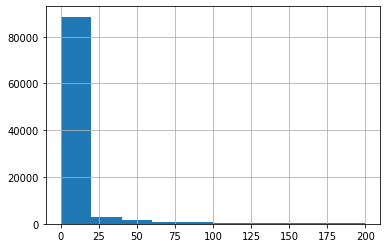

In [22]:
# Смотрим, каких дельт между днями больше всего. Дельт больше 50 (например) почти нет, значит можно сделать вывод, что 
# пользователей, которые отсутсвуют 50 дней, не проходят после  курс. А дельт меньше 10 очень много, это значит, что 
# пользователи часто возвращаются к следующим заданиям

gap_data[gap_data < 200].hist()

In [23]:
# Посчитаем более точно. 90% всех наблюдений лежит до 18.3 дней. То есть только 10% пользователей возвращается на курс, если
# у них между днями разрыв 18 дней. 

gap_data.quantile(0.90)

18.325995370370403

### Задача про Карпова. Надо найти его среди других пользователей

In [24]:
# Сначала создаем таблицу со датой первой активности пользователя
first_action_date = events_data[['date', 'user_id']].groupby('user_id', as_index=False).min()

In [25]:
# Добавляем эти данные к таблице с количество активностей и сортируем. Анатолий в топ 5

pivot_events.merge(first_action_date).sort_values(by=['viewed', 'date'], ascending=False)

,user_id,discovered,passed,started_attempt,viewed,date
15007,20907,163,102,0,32778,2015-06-15 05:37:25
7780,10794,198,122,27,16089,2016-08-02 00:44:34
18150,25279,198,122,166,9693,2017-06-05 05:00:21
781,1046,128,124,721,8122,2015-06-15 06:58:39
2611,3572,194,193,550,6968,2017-07-13 09:21:28
...,...,...,...,...,...,...
9486,13181,0,0,7,0,2018-04-19 11:20:00
6334,8773,0,0,1,0,2018-03-10 20:32:18
19026,26502,0,0,1,0,2017-10-20 11:07:11
13536,18842,0,1,1,0,2016-09-19 17:29:05


### Конец задачи

Продолжаем составлять таблицу с данными о юзере. Считаем отвалившихся юзеров (кого нет больше 30 дней на курсе)

In [26]:
# Возьмем 30 дней - порог, после которого признаем пользователя отвалившимся (не пройдет курс, если отсутсвует более 30 дней)
# Посмотрим дату последней активности на курсе (дата, когда выгрузили данные) и вычтем из нее последнюю активность каждого 
# пользователя

In [27]:
# Запишем время выгрузки данных и порог, когда признаем пользователя отвалившимся

course_last_timestamp = 1526772811
drop_out_threshold = 30 * 24 * 60 * 60

In [28]:
# Cоздадим df, где будет последнее время активности для каждого пользователя

user_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'})
user_data

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


In [29]:
# Предварительно поставим всем пользователям, у которых между последним действием прошло больше 30 дней, галочку, что они
# отвалились 

user_data['is_gone_user'] = (course_last_timestamp - user_data.last_timestamp) >= drop_out_threshold
user_data

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [30]:
# Присоединим к этому датафрейму дф с данными о правильных и неправильных выполнениях заданий

user_data = user_data.merge(users_score, how='outer')

In [31]:
# У пользователей, у которых нет данных о выполнении заданий (они не выполняли ничего), проставим нули

user_data.fillna(0, inplace=True)
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [32]:
# Присоединим данные про шаги (раскопал, прошел, увидел)

user_data = user_data.merge(pivot_events, how='outer')

In [33]:
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9
19230,26793,1510225034,True,0.0,0.0,1,0,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180
19232,26797,1509995096,True,2.0,0.0,10,10,2,13


In [34]:
# Добавим данные об уникальных днях пользователя

user_data = user_data.merge(events_data.groupby('user_id', as_index=False).day.nunique(), how='outer')

In [35]:
user_data.rename(columns={'day': 'unique_days'}, inplace=True)
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


In [36]:
# Добавим колонку прошел ли пользователь курс (считается пройденным, если набрал больше 170 баллов)

user_data['passed_course'] = user_data.passed > 170
user_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


In [37]:
# Добавим колонку для задания. Если пользователь набрал больше 40 баллов, мы пометим его галочкой 

user_data['is_scored_40_points'] = user_data.passed >= 40

In [38]:
# Доля студентов, которые набрали 40 очков

user_data.is_scored_40_points.sum() / user_data.shape[0] 

0.24706249350109183

In [39]:
# Посмотрим, сколько в среднем уникальных дней пользователи проходят курс

In [40]:
user_data.query('passed_course == False').unique_days.median()

1.0

In [41]:
user_data.query('passed_course == True').unique_days.median()

20.0

### Большая табличка со многими данными о полоьзователе готова

In [42]:
user_data.shape

(19234, 12)

In [43]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course,is_scored_40_points
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,True
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,False


# Табличка с событиями в первые три дня

Будем отбирать события для пользователя, которые произошли с пользоватлем в первые три дня. Нам нужно угадывать уже в первые дни, отвалится пользователь или нет, поэтому будем обучать модельку на первых трех днях

In [44]:
# Три дня в секундах

learning_time_treshold = 3 * 24 * 60 * 60

In [45]:
min_user_timestamp = events_data.groupby('user_id').timestamp.min()

In [46]:
user_data = user_data.merge(min_user_timestamp, on='user_id', how='outer')

In [47]:
user_data.rename({'timestamp': 'min_timestamp'}, axis=1, inplace=True)

In [48]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course,is_scored_40_points,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,True,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,False,1521634660


### Создаем таблички, в которой будут только данные за первые три дня

In [49]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [50]:
# В этом дф будут хранится данные о ивентах за первые три дня

events_data_train = events_data.merge(min_user_timestamp, on='user_id', how='outer')

In [51]:
events_data_train.head()

,step_id,timestamp_x,action,user_id,date,day,timestamp_y
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [52]:
events_data_train.rename({'timestamp_x': 'timestamp', 'timestamp_y': 'min_timestamp'}, axis=1, inplace=True)

In [53]:
# Отбираем ячейки, которые укладываются в диапазон "первый timestamp юзера + 3 дня"

events_data_train = events_data_train[events_data_train.timestamp <= events_data_train.min_timestamp + learning_time_treshold]

In [54]:
events_data_train.shape

(1014985, 7)

In [55]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [56]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [57]:
# Сделаем тоже самое для submissions_data

submissions_data_train = submissions_data.merge(min_user_timestamp, on='user_id', how='outer')

In [58]:
submissions_data_train.rename({'timestamp_x': 'timestamp', 'timestamp_y': 'min_timestamp'}, axis=1, inplace=True)

In [59]:
submissions_data_train = submissions_data_train.query(f'timestamp <= min_timestamp + {learning_time_treshold}')

In [60]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977


### Формируем финальный датафрейм с событиями в первые три дня для пользователя

Формируем датафрейм со сложными шагами и соотношением сложных шагов к простым для каждого юзера (используем функции из stepik_ml_test_data.ipynb

In [61]:
steps_scores = calculate_user_step_score(events_data_train, submissions_data_train)

In [62]:
events_data_train = events_data_train.merge(steps_scores)

In [63]:
difficult_steps_df = count_difficult_steps_per_user(events_data_train) 

In [64]:
difficult_steps_df.drop(['count_steps', 'is_difficult'], axis=1, inplace=True)

In [65]:
difficult_steps_df

,user_id,difficult_ratio
0,2,0.000000
1,3,0.000000
2,5,0.000000
3,7,0.000000
4,8,0.035714
...,...,...
17226,26789,0.000000
17227,26790,0.000000
17228,26794,0.016393
17229,26797,0.000000


In [66]:
# Посчитаем количество уникальных дней для каждого пользователя и количество степов, которые он попытался пройти

X = submissions_data_train.groupby('user_id', as_index=False).day.nunique()

In [67]:
X.head()

,user_id,day
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [68]:
X = X.merge(difficult_steps_df, on='user_id')

In [69]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique()

In [70]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [71]:
X = X.rename({'day': 'unique_days', 'step_id': 'tried_steps'}, axis=1)

In [72]:
X.head()

,user_id,unique_days,difficult_ratio,tried_steps
0,2,1.0,0.000000,2
1,3,1.0,0.000000,4
2,8,1.0,0.035714,11
3,14,1.0,0.000000,1
4,16,3.0,0.018182,23


In [73]:
three_day_correct = submissions_data_train.pivot_table(columns='submission_status', values='step_id', 
                                   index='user_id', aggfunc='count', fill_value=0) \
                                   .reset_index()

In [74]:
three_day_correct.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27


In [75]:
X = X.merge(three_day_correct, on='user_id', how='outer')

In [76]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [77]:
X.head()

,user_id,unique_days,difficult_ratio,tried_steps,correct,wrong,correct_ratio
0,2,1.0,0.000000,2,2,0,1.00
1,3,1.0,0.000000,4,4,4,0.50
2,8,1.0,0.035714,11,9,21,0.30
3,14,1.0,0.000000,1,0,1,0.00
4,16,3.0,0.018182,23,23,27,0.46


In [78]:
viewed_steps_per_user  = events_data_train.pivot_table(index='user_id', columns='action', 
                              values='day', aggfunc='count', fill_value=0) \
                              .reset_index()

In [79]:
viewed_steps_per_user.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1


In [80]:
X = X.merge(viewed_steps_per_user, on='user_id', how='outer')

In [81]:
X.fillna(0, inplace=True)

In [82]:
X.head()

,user_id,unique_days,difficult_ratio,tried_steps,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
0,2,1.0,0.000000,2.0,2.0,0.0,1.00,9,9,2,9
1,3,1.0,0.000000,4.0,4.0,4.0,0.50,15,15,4,20
2,8,1.0,0.035714,11.0,9.0,21.0,0.30,109,84,37,154
3,14,1.0,0.000000,1.0,0.0,1.0,0.00,4,3,1,9
4,16,3.0,0.018182,23.0,23.0,27.0,0.46,55,55,26,132


In [83]:
# Теперь добавим инфу про то, прошел ли юзер курс и можно ли его считать отвалившимся

X = X.merge(user_data[['user_id', 'is_gone_user', 'passed_course']], on='user_id', how='outer')

In [84]:
# Уберем пользователей, которые еще не прошли курс, но и не бросили (мы ничего по ним сказать не можем)
# ТИЛЬДА ЭТО ОТРИЦАНИЕ!!!
X = X.query('~(passed_course == False & is_gone_user == False)')

In [85]:
# Убираем лишние колонки

X.drop(['is_gone_user', 'passed_course'], axis=1, inplace=True)

In [86]:
X.shape

(17985, 11)

In [87]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,unique_days,passed_course,is_scored_40_points,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,True,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,False,1521634660


В **y** поместим переменную, набрал ли пользователь 40 баллов. Смержим, чтобы убрать юзеров, которые и не прошли курс, и не отвалились

In [88]:
y_train = X.merge(user_data[['user_id', 'is_scored_40_points']], on='user_id')['is_scored_40_points']

In [89]:
X.set_index(X.user_id, inplace=True)

In [90]:
X_train = X.drop('user_id', axis=1)

In [91]:
X_train.head()

,unique_days,difficult_ratio,tried_steps,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
user_id,,,,,,,,,,
2,1.0,0.000000,2.0,2.0,0.0,1.00,9,9,2,9
3,1.0,0.000000,4.0,4.0,4.0,0.50,15,15,4,20
8,1.0,0.035714,11.0,9.0,21.0,0.30,109,84,37,154
14,1.0,0.000000,1.0,0.0,1.0,0.00,4,3,1,9
16,3.0,0.018182,23.0,23.0,27.0,0.46,55,55,26,132


In [92]:
X_train.shape

(17985, 10)

## Функции для решения

In [135]:
def is_gone_predict__proba(clf, data):
    is_gone_proba = clf.predict_proba(data)
    data = data.reset_index()
    return pd.DataFrame({'user_id': data.user_id, 'is_gone': is_gone_proba[:, 1]})

# Обучение моделей

### RandomForest

In [94]:
rf_clf = ensemble.RandomForestClassifier()

In [95]:
best_rf_params = {'max_depth': 4,
                  'min_samples_leaf': 13,
                  'min_samples_split': 5,
                  'n_estimators': 30}

In [96]:
rf_params = {'n_estimators': range(30, 50, 5), 'max_depth': range(1, 5), 
             'min_samples_leaf': range(1, 20, 4), 'min_samples_split': range(1, 20, 4)}

In [97]:
# search_rf = GridSearchCV(rf_clf, rf_params, cv=5, n_jobs=-1, verbose=1)

In [98]:
# search_rf.fit(X_train, y_train)

In [99]:
# search_rf.best_params_

In [100]:
# search_rf.best_score_

In [101]:
# best_rf_clf = search_rf.best_estimator_

In [102]:
best_rf_clf = ensemble.RandomForestClassifier(**best_rf_params)

In [103]:
best_rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=13, min_samples_split=5,
                       n_estimators=30)

In [104]:
best_rf_clf.score(X_train, y_train)

0.8700027800945233

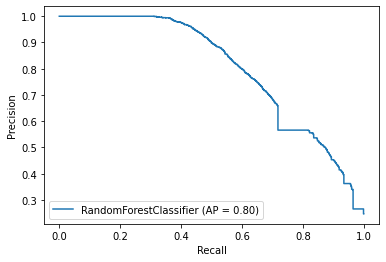

In [105]:
metrics.plot_precision_recall_curve(best_rf_clf, X_train, y_train)

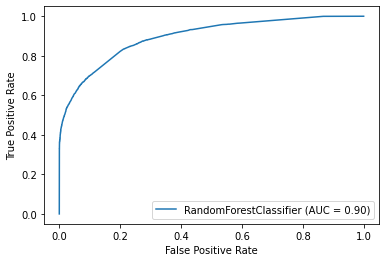

In [106]:
metrics.plot_roc_curve(best_rf_clf, X_train, y_train)

In [107]:
metrics.roc_auc_score(best_rf_clf.predict(X_train), y_train)

0.8593020984939016

In [108]:
pd.DataFrame({'name': list(X_train), 'importances': best_rf_clf.feature_importances_})

,name,importances
0,unique_days,0.010934
1,difficult_ratio,0.000155
2,tried_steps,0.146985
3,correct,0.174041
4,wrong,0.001338
5,correct_ratio,0.019885
6,discovered,0.136928
7,passed,0.395260
8,started_attempt,0.052684
9,viewed,0.061790


In [109]:
is_gone_proba = best_rf_clf.predict_proba(user_score_test)

In [110]:
is_gone_df = pd.DataFrame({'user_id': user_score_test.reset_index().user_id, 'is_gone': is_gone_proba[:, 1]})

In [111]:
is_gone_df.to_csv('./data_files/is_gone_rf.csv')

,user_id,is_gone
0,4,0.044969
1,6,0.044969
2,10,0.106004
3,12,0.179412
4,13,0.466511
...,...,...
6179,26791,0.044969
6180,26795,0.044969
6181,26796,0.206538
6182,26799,0.126504


### GradientBoostingClassifier

In [112]:
gbc = ensemble.GradientBoostingClassifier()

In [113]:
gb_best_params = {'learning_rate': 0.16000000000000003, 'max_depth': 2, 'n_estimators': 95}

In [114]:
# gb_params = {'n_estimators': range(10, 100, 5), 'max_depth': range(1, 5), 'learning_rate': np.arange(0.01, 0.5, 0.05)}

In [115]:
# search_gb = GridSearchCV(gbc, gb_params, cv=5, n_jobs=-1, verbose=1)

In [116]:
# search_gb.fit(X_train, y_train)

In [117]:
# search_gb.best_score_

In [118]:
# search_gb.best_params_

In [119]:
# best_gb_clf = search_gb.best_estimator_

In [120]:
best_gb_clf = ensemble.GradientBoostingClassifier(**gb_best_params)

In [121]:
best_gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.16000000000000003, max_depth=2,
                           n_estimators=95)

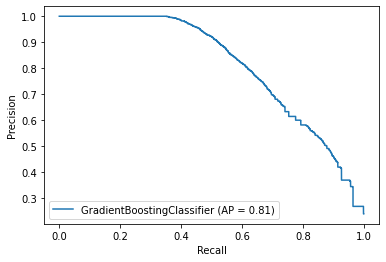

In [122]:
metrics.plot_precision_recall_curve(best_gb_clf, X_train, y_train)

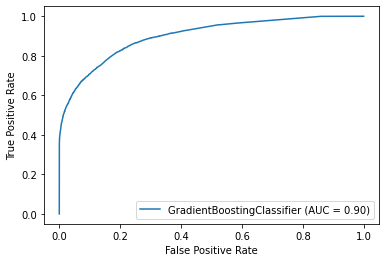

In [123]:
metrics.plot_roc_curve(best_gb_clf, X_train, y_train)

In [124]:
metrics.roc_auc_score(best_gb_clf.predict(X_train), y_train)

0.8658344622546749

In [137]:
gb_is_gone_proba = is_gone_predict__proba(best_gb_clf, user_score_test)

In [138]:
gb_is_gone_proba.to_csv('./data_files/is_gone_gb.csv')

### KNeihbors

In [125]:
neighbors_clf = neighbors.KNeighborsClassifier()

In [126]:
neighbors_params = {'n_neighbors': range(1, 30)}

In [127]:
neighbors_search = GridSearchCV(neighbors_clf, neighbors_params, cv=5, n_jobs=-1, verbose=True)

In [128]:
neighbors_search.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:   24.9s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 30)}, verbose=True)

In [129]:
neighbors_search.best_score_

0.8316374756741729

In [130]:
neighbors_search.best_params_

{'n_neighbors': 2}

In [131]:
best_neighbors_clf = neighbors_search.best_estimator_

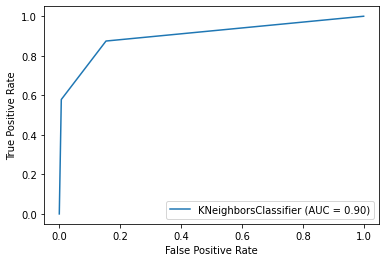

In [132]:
metrics.plot_roc_curve(best_neighbors_clf, X_train, y_train)

In [133]:
metrics.roc_auc_score(best_neighbors_clf.predict(X_train), y_train)

0.9238875371213512

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here